<p style="border: 1px solid #1CBCFF; border-left: 15px solid #1CBCFF; padding: 10px; text-align:justify;">
    <strong style="color: #1CBCFF">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter03/ch3_nb1_discover_cnns_basic_ops.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #363636;">Mastering Deep Learning with Tensorflow 2.1<br/>by <em>Rajdeep Dua</em> </strong><br/><br/>
        <strong>Chapter 4: Convolutional Neural Networks</strong><br/>Build and Train first CNN with TF 2.1
 </p>


<br/>
<p style="border-left: 15px solid #363636; padding: 0 10px; text-align:justify;">
<strong style="color: #363636;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Mastering Deep Learning with Tensorflow 2.1</strong></em>" written by Rajdeep Dua, published by BPB. If you enjoyed the insights shared here, <a href=".." title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>

In [3]:
import tensorflow as tf

## Preparing the Data

As presented in Chapter 4, we use Tensorflow and Keras helpers to load the Fashion MNIST dataset

In [4]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

## Building and Training LeNet-5

We have demonstrated how CNNs can be implemented different ways depending on the _level of parametrization_ versus _succinctness_ one needs. In this case, we will use the Keras API to showcase once again how straightforward it makes implementing and using neural networks.

### Instantiating Convolutional Layers

In the previous notebook, we presented how one can perform convolutions on images. However, in neural networks, we want the convolutions' filters to be ***trainable***, and we may want to add a ***bias*** to the results and apply an ***activation function***.

We thus need to wrap the convolution operation into a `Layer` object, similar to how the fully-connected layer we implemented in Chapter 1 was built around the matrix operations.

TensorFlow 2/Keras provides its own `tf.keras.Layer` class we can extend. We demonstrate below how a simple convolution layer can be dfined this way:

In [7]:
class SimpleConvolutionLayer(tf.keras.layers.Layer):

    def __init__(self, num_kernels=32, kernel_size=(3, 3), strides=(1, 1), use_bias=True):
        """
        Initialize the layer.
        :param num_kernels:     Number of kernels for the convolution
        :param kernel_size:     Kernel size (H x W)
        :param strides:         Vertical and horizontal stride as list
        :param use_bias:        Flag to add a bias after covolution / before activation
        """
        # First, we have to call the `Layer` super __init__(), as it initializes hidden mechanisms:
        super().__init__()  
        # Then we assign the parameters:
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.strides = strides
        self.use_bias = use_bias

    def build(self, input_shape):
        """
        Build the layer, initializing its parameters according to the input shape.
        This function will be internally called the first time the layer is used, though
        it can also be manually called.
        :param input_shape:     Input shape the layer will receive (e.g. B x H x W x C)
        """
        # We are provided with the input shape here, so we know the number of input channels:
        num_input_channels = input_shape[-1]  # assuming shape format BHWC

        # Now we know how the shape of the tensor representing the kernels should be:
        kernels_shape = (*self.kernel_size, num_input_channels, self.num_kernels)

        # For this example, we initialize the filters with values picked from a Glorot distribution:
        glorot_uni_initializer = tf.initializers.GlorotUniform()
        self.kernels = self.add_weight(name='kernels',
                                       shape=kernels_shape,
                                       initializer=glorot_uni_initializer,
                                       trainable=True)  # and we make the variable trainable.

        if self.use_bias:  # If bias should be added, we initialize its variable too:
            self.bias = self.add_weight(name='bias',
                                        shape=(self.num_kernels,),
                                        initializer='random_normal',  # e.g., using normal distribution.
                                        trainable=True)

    def call(self, inputs):
        """
        Call the layer and perform its operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """
        # We perform the convolution:
        z = tf.nn.conv2d(inputs, self.kernels, strides=[1, *self.strides, 1], padding='VALID')

        if self.use_bias:  # we add the bias if requested:
            z = z + self.bias
        # Finally, we apply the activation function (e.g. ReLU):
        return tf.nn.relu(z)

    def get_config(self):
        """
        Helper function to define the layer and its parameters.
        :return:        Dictionary containing the layer's configuration
        """
        return {'num_kernels': self.num_kernels,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'use_bias': self.use_bias}

Most of TensorFlow mathematical operations (e.g. in `tf.maths` and `tf.nn`) already have their derivatives defined by the framework. 
Therefore, as long as a layer is composed of such operations, **we do not have to manually define its backward propagation**. TensorFlow will automatically cover this, which saves a lot of efforts!

The convolutional layer we just implemented is therefore fully operational, and ready to be used inside a CNN, as we will demonstrate right away.

***Note:*** As convolutional layers are the most basic component of CNNs, TensorFlow obviously provides its own `tf.keras.layers.Conv2D` class. The module `tf.keras.layers` contains a large variety of pre-implemented standard layers, which we recommend to use whenever possible (as they have more advacned interfaces and optimized operations). For the sake of demonstration, we will still stick to our own simpler `SimpleConvolutionLayer` for the rest of this notebook, while using other Keras pre-defined layers.

### Implementing LeNet-5

***LeNet-5***[$^2$](#ref) is a simple CNN composed of 7 layers (2 *conv*, 2 *max-pool*, 3 *FC* + 1 helper layer to flatten the feature maps before the *FC*). For more details, we invite our readers to go back to Chapter 3.

Below, we thus present how one can extend the `tf.keras.Model` class to define a custom architecture:

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [9]:
class LeNet5(Model):
    
    def __init__(self, num_classes):
        """
        Initialize the model.
        :param num_classes:     Number of classes to predict from
        """
        super(LeNet5, self).__init__()
        # We instantiate the various layers composing LeNet-5:
        # self.conv1 = SimpleConvolutionLayer(6, kernel_size=(5, 5))
        # self.conv2 = SimpleConvolutionLayer(16, kernel_size=(5, 5))
        # ... or using the existing and (recommended) Conv2D class:
        self.conv1 = Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu')
        self.conv2 = Conv2D(16, kernel_size=(5, 5), activation='relu')
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')
        self.dense3 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        """
        Call the layers and perform their operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """
        x = self.max_pool(self.conv1(inputs))        # 1st block
        x = self.max_pool(self.conv2(x))             # 2nd block
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x))) # dense layers
        return x

## Classiyfing MNIST with a CNN


Now we can instantiate and compile our model for digit classification. To train it for this task, we instantiate the optimizer (a simple _SGD_ one for this example) and define the loss (the _categorical cross-entropy_).

***Note:*** The Keras loss named `"sparse_categorical_crossentropy"` performs the same cross-entropy operation as the `"categorical_crossentropy"`, but the former directly takes the ground-truth labels as inputs, while the latter requires the ground-truth labels to be _one-hotted_ before. Using the `"sparse_..."` loss thus saves us from manually having to transform the labels... 

In [10]:
model = LeNet5(num_classes)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Having sub-classed `tf.keras.Model`, our model has all its functionalities. For instance, we can call `model.summary()` to print a summary of its architecture:

In [11]:
# We can call `model.summary()` only if the model was built before. 
# It is normally done automatically at the first use of the network,
# inferring the input shapes from the samples the network is given.
# For instance, the command below would build the network (then use it for prediction):
_ = model.predict(x_test[:10])

# But we can build the model manually otherwise, providing the batched
# input shape ourselves:
batched_input_shape = tf.TensorShape((None, *input_shape))
model.build(input_shape=batched_input_shape)

# Method to visualize the architecture of the network:
model.summary()

Model: "le_net5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  156       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  48120     
_________________________________________________________________
dense_1 (Dense)              multiple                  10164     
_________________________________________________________________
dense_2 (Dense)              multiple                  850 

Before launching the training, we also instantiate some Keras callbacks, i.e., utility functions automatically called at specific points during the training (before/after batch training, before/after a full epoch, etc.), in order to monitor it:

In [12]:
callbacks = [
    # Callback to interrupt the training if the validation loss (`val_loss`) stops improving for over 3 epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # Callback to log the graph, losses and metrics into TensorBoard (saving log files in `./logs` directory):
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)]

(The Tensorboard callback allows us to monitor the training from Tensorboard. For that, open a console and launch the programm with the command "`tensorboard --logdir=./logs`". You can then access Tensorboard from a browser, via the URL "[`localhost:6006`](localhost:6006)".)

We can now pass everything to our model to train it:


In [13]:
history = model.fit(x_train, y_train,
                    batch_size=32, epochs=80, validation_data=(x_test, y_test), 
                    verbose=2,  # change to `verbose=1` to get a progress bar
                                # (we opt for `verbose=2` here to reduce the log size)
                    callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/80
60000/60000 - 14s - loss: 0.8104 - accuracy: 0.7016 - val_loss: 0.5924 - val_accuracy: 0.7780
Epoch 2/80
60000/60000 - 14s - loss: 0.4919 - accuracy: 0.8202 - val_loss: 0.4545 - val_accuracy: 0.8361
Epoch 3/80
60000/60000 - 14s - loss: 0.4241 - accuracy: 0.8470 - val_loss: 0.4335 - val_accuracy: 0.8423
Epoch 4/80
60000/60000 - 14s - loss: 0.3870 - accuracy: 0.8597 - val_loss: 0.4021 - val_accuracy: 0.8558
Epoch 5/80
60000/60000 - 12s - loss: 0.3616 - accuracy: 0.8695 - val_loss: 0.3949 - val_accuracy: 0.8610
Epoch 6/80
60000/60000 - 13s - loss: 0.3427 - accuracy: 0.8756 - val_loss: 0.3615 - val_accuracy: 0.8722
Epoch 7/80
60000/60000 - 14s - loss: 0.3279 - accuracy: 0.8804 - val_loss: 0.3789 - val_accuracy: 0.8619
Epoch 8/80
60000/60000 - 13s - loss: 0.3154 - accuracy: 0.8851 - val_loss: 0.3465 - val_accuracy: 0.8728
Epoch 9/80
60000/60000 - 14s - loss: 0.3055 - accuracy: 0.8876 - val_loss: 0.3594 - val_accuracy: 0.8699
Epoch

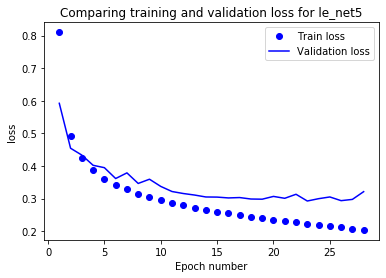

In [14]:
import sys; sys.path.append('..')
from common.plot_util import eval_metric
EPOCHS=28
%matplotlib inline
eval_metric(model,history, 'loss',EPOCHS)

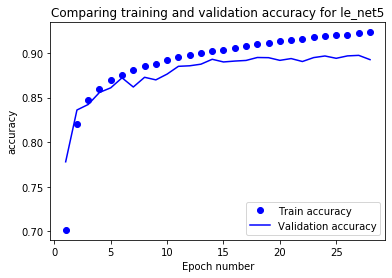

In [15]:
eval_metric(model,history, 'accuracy',EPOCHS)

## Conclusion

Given a machine with recent GPU(s), this training is quite fast (~0.1ms/image in our case). The final accuracy we obtain on the validation dataset (**~98%!**) is also much better compared to our previous attempts with simpler networks. Indeed, the relative error has been approximately divided by 2, which is a significant improvement.

<a id="ref"></a>
#### References

1. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.
2. LeCun, Yann. "*LeNet-5, convolutional neural networks.*" [http://yann.lecun.com/exdb/lenet](http://yann.lecun.com/exdb/lenet) (2015): 20.